## Julia Jupyter Notebook File to run optimization on

In [187]:
using Pkg
Pkg.add.(["IJulia", "JuMP", "Gurobi", "Shapefile", "DataFrames", "CSV"])

# Read ACS geodatabase with ArchGDAL (no ogr/gdal CLI needed)
using Pkg
Pkg.add("ArchGDAL")


   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.

In [188]:
Pkg.add("HTTP")
Pkg.add("JSON3")

   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


In [189]:
using Shapefile, DataFrames, Plots

shp = Shapefile.Table("tl_2021_36_bg/tl_2021_36_bg.shp")

df = DataFrame(shp)  # attributes + geometries

df_queens = filter(row -> row.COUNTYFP == "081", df)

row = df_queens[1, :]
geom = row.geometry

xs = [pt.x for pt in geom.parts[1].points]
ys = [pt.y for pt in geom.parts[1].points]

plot(xs, ys, aspect_ratio=:equal, legend=false, title="One block group in Queens")



FieldError: FieldError: type Int32 has no field `points`; Int32 has no fields at all.

In [190]:
using Shapefile, DataFrames

table = Shapefile.Table("tl_2021_36_bg/tl_2021_36_bg.shp")
nyc = filter(row -> row.COUNTYFP in ("005","047","061","081"), DataFrame(table)) # drop Staten Island 085

function ring_centroid(ring)
    cross_sum = 0.0; cx = 0.0; cy = 0.0
    for i in 1:length(ring)-1
        x0,y0 = ring[i].x, ring[i].y
        x1,y1 = ring[i+1].x, ring[i+1].y
        cross = x0*y1 - x1*y0
        cross_sum += cross
        cx += (x0 + x1) * cross
        cy += (y0 + y1) * cross
    end
    (cx/(3 * cross_sum), cy/(3 * cross_sum), cross_sum / 2) # returns (cx, cy, signed area)
end

function centroid_of_geom(poly::Shapefile.Polygon)
    pts, parts = poly.points, poly.parts
    rings = [pts[p+1 : (i == length(parts) ? length(pts) : parts[i+1])]
             for (i, p) in enumerate(parts)]
    area = 0.0; cx = 0.0; cy = 0.0
    for r in rings
        rcx, rcy, ra = ring_centroid(r)
        area += ra; cx += rcx * ra; cy += rcy * ra
    end
    (cx / area, cy / area)
end

# compute centroids and attach as a column
nyc.centroid = centroid_of_geom.(nyc.geometry)

using Serialization

open("nyc_with_centroid.jls", "w") do io
    serialize(io, nyc)
end
println("Saved nyc (with :centroid) to nyc_with_centroid.jls")


Saved nyc (with :centroid) to nyc_with_centroid.jls


In [191]:
nyc

6433×14 DataFrame
  Row │ geometry             STATEFP  COUNTYFP  TRACTCE  BLKGRPCE  GEOID       ⋯
      │ Polygon?             String?  String?   String?  String?   String?     ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ Polygon(74 Points)   36       047       031401   3         36047031401 ⋯
    2 │ Polygon(24 Points)   36       047       107003   1         36047107003
    3 │ Polygon(147 Points)  36       047       107002   1         36047107002
    4 │ Polygon(52 Points)   36       047       103402   1         36047103402
    5 │ Polygon(11 Points)   36       047       001801   2         36047001801 ⋯
    6 │ Polygon(66 Points)   36       047       001802   1         36047001802
    7 │ Polygon(28 Points)   36       047       061004   5         36047061004
    8 │ Polygon(119 Points)  36       047       005302   2         36047005302
  ⋮   │          ⋮              ⋮        ⋮         ⋮        ⋮           ⋮      ⋱
 6427 │ Polygon(14 Points)   36       061       024100   2         36061024100 ⋯
 6428 │ Polygon(54 Points)   36       061       027500   1         36061027500
 6429 │ Polygon(55 Points)   36       061       028300   2         36061028300
 6430 │ Polygon(10 Points)   36       061       028500   1         36061028500
 6431 │ Polygon(6 Points)    36       061       028500   2         36061028500 ⋯
 6432 │ Polygon(10 Points)   36       061       029100   4         36061029100
 6433 │ Polygon(11 Points)   36       061       023803   0         36061023803
                                                 9 columns and 6418 rows omitted

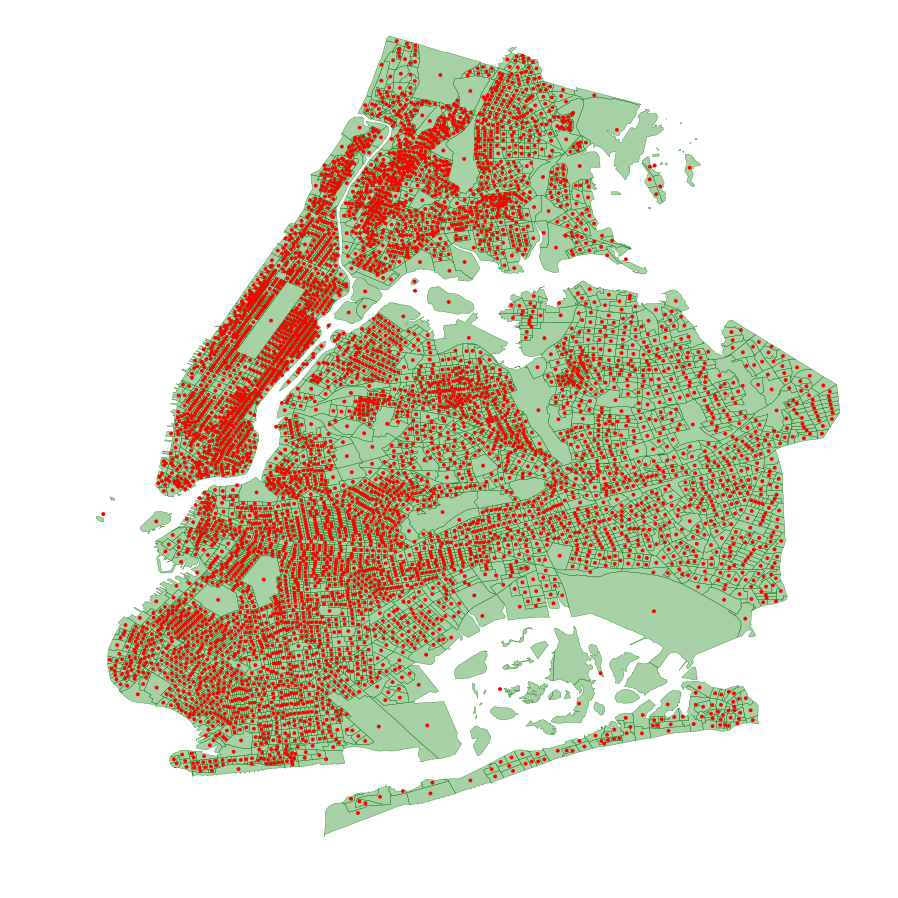

In [192]:
# Extract rings for plotting
function rings(poly::Shapefile.Polygon)
    pts, parts = poly.points, poly.parts
    [pts[p+1 : (i == length(parts) ? length(pts) : parts[i+1])]
     for (i, p) in enumerate(parts)]
end

# keep only land block groups (ALAND > 0)
nyc_land = filter(:ALAND => >(0), nyc)

plt = plot(legend=false, size=(900, 900), aspect_ratio=:equal,
           grid=false, axis=false, background_color=:white)

for g in nyc_land.geometry
    for r in rings(g)
        xs = getfield.(r, :x); ys = getfield.(r, :y)
        if first(xs) != last(xs) || first(ys) != last(ys)
            xs = vcat(xs, first(xs)); ys = vcat(ys, first(ys))
        end
        plot!(plt, xs, ys,
              seriestype=:shape,
              fillcolor=:green, fillalpha=0.35,
              linecolor=:darkgreen, linewidth=0.3)
    end
end

scatter!(plt,
    [c[1] for c in nyc_land.centroid],
    [c[2] for c in nyc_land.centroid],
    color=:darkred, markersize=1.2, alpha=1.0, markerstrokecolor=:red, label="centroid")

savefig(plt, "nyc_bg_centroids.png")
plt



In [193]:
using CSV, DataFrames

csv_path = joinpath("DECENNIALPL2020.P1_2025-12-07T165116", "DECENNIALPL2020.P1-Data.csv")

if !isfile(csv_path)
    error("CSV file not found at: $(csv_path). Check the working directory (pwd()) or provide the correct path.")
end

# Read the CSV into a DataFrame
df_census = CSV.read(csv_path, DataFrame)

# Quick summary
println("Loaded CSV: $(csv_path)")
println("Rows: $(size(df_census,1)), Columns: $(size(df_census,2))")

# Show first few rows
first(df_census, 10)

Loaded CSV: DECENNIALPL2020.P1_2025-12-07T165116/DECENNIALPL2020.P1-Data.csv
Rows: 33313, Columns: 74


10×74 DataFrame
 Row │ GEO_ID                    NAME                               P1_001N    ⋯
     │ String31                  String                             String15   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Geography                 Geographic Area Name                !!Total:  ⋯
   2 │ 1000000US360050001000001  Block 0001, Block Group 0, Censu…  0
   3 │ 1000000US360050001000002  Block 0002, Block Group 0, Censu…  0
   4 │ 1000000US360050001001000  Block 1000, Block Group 1, Censu…  171
   5 │ 1000000US360050001001001  Block 1001, Block Group 1, Censu…  1344       ⋯
   6 │ 1000000US360050001001002  Block 1002, Block Group 1, Censu…  367
   7 │ 1000000US360050001001003  Block 1003, Block Group 1, Censu…  1890
   8 │ 1000000US360050002000001  Block 0001, Block Group 0, Censu…  0
   9 │ 1000000US360050002001000  Block 1000, Block Group 1, Censu…  310        ⋯
  10 │ 1000000US360050002001001  Block 1001, Block Group 1, Censu…  274
                                                              71 columns omitted

In [194]:
using DataFrames

# --- 0. Make sure IDs are Strings ---
df_pop.GEO_ID      = String.(df_pop.GEO_ID)
df_centroids.GEOID = String.(df_centroids.GEOID)

# --- 1. Robustly convert P1_001N from String → Union{Missing, Int} ---
raw_pop = String.(df_pop.P1_001N)

pop_parsed = Vector{Union{Missing, Int}}(undef, length(raw_pop))

for i in eachindex(raw_pop)
    s = strip(raw_pop[i])
    if isempty(s)
        pop_parsed[i] = missing
    else
        try
            pop_parsed[i] = parse(Int, s)
        catch
            pop_parsed[i] = missing   # e.g. header row or non-numeric junk
        end
    end
end

df_pop.P1_001N = pop_parsed
dropmissing!(df_pop, :P1_001N)   # keep only rows with valid population

# --- 2. Function: block GEO_ID → block-group GEOID (state+county+tract+bg) ---
function block_to_blockgroup_geoid(geo_id::AbstractString)
    s = String(geo_id)

    # Expect: 1000000US + 2-digit state + 3-digit county + 6-digit tract + 4-digit block
    m = match(r"^1000000US(\d{2})(\d{3})(\d{6})(\d{4})$", s)
    if m === nothing
        return missing  # summary rows, etc.
    end

    state, county, tract, block = m.captures
    bg = block[1]  # first digit of block code = block group
    return string(state, county, tract, bg)
end

# --- 3. Add block-group GEOID; drop non-block rows ---
df_pop.GEOID_BG = block_to_blockgroup_geoid.(df_pop.GEO_ID)
df_pop_blocks   = dropmissing(df_pop, :GEOID_BG)

# --- 4. Aggregate block populations → block-group population ---
df_bg_pop = combine(groupby(df_pop_blocks, :GEOID_BG),
                    :P1_001N => sum => :population)

# --- 5. Join with centroids on block-group GEOID ---
df_joined = innerjoin(df_centroids, df_bg_pop,
                      on = :GEOID => :GEOID_BG)

# --- 6. Final dataframe: GEO_ID (block-group style), population, centroid ---
df_final = select(df_joined,
                  :GEOID => :GEO_ID,
                  :population,
                  :centroid)

first(df_final, 5)


MethodError: MethodError: no method matching String(::Int64)
The type `String` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  String(!Matched::StringManipulation.Decoration)
   @ StringManipulation ~/.julia/packages/StringManipulation/SXVLT/src/decorations.jl:362
  String(!Matched::Vector{UInt8})
   @ Base strings/string.jl:65
  String(!Matched::Symbol)
   @ Base strings/string.jl:118
  ...


In [217]:
using DataFrames, CSV

# Remove block groups with zero population
df_final = filter(:population => x -> x > 0, df_final)

# (Optional) also drop missing population just in case
df_final = dropmissing(df_final, :population)

# Save to CSV
CSV.write("nyc_blockgroups_centroids_population.csv", df_final)

first(df_final, 5), nrow(df_final)


(5×5 DataFrame
 Row │ GEO_ID        population  centroid                           centroid_l ⋯
     │ Int64         Int64       String                             Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 360050001001        3772  (-73.88268621619711, 40.79111365…      -73.88 ⋯
   2 │ 360050002001        1330  (-73.8608670825381, 40.813963606…      -73.86
   3 │ 360050002002        2057  (-73.86005437091085, 40.81139700…      -73.86
   4 │ 360050002003        1392  (-73.85667782135997, 40.80817956…      -73.85
   5 │ 360050004001        1047  (-73.85734488948857, 40.81397824…      -73.85 ⋯
                                                               2 columns omitted, 6164)

# Cleaner

In [218]:
using DataFrames

# df_final already loaded from CSV
# and has a `centroid` column that looks like "(-73.9924, 40.5866)"

function parse_centroid(s::AbstractString)
    # Remove parentheses
    t = strip(s, ['(', ')'])
    parts = split(t, ",")
    lon = parse(Float64, strip(parts[1]))
    lat = parse(Float64, strip(parts[2]))
    return lon, lat
end

# Create numeric lon/lat columns from centroid strings
centroid_lons = Float64[]
centroid_lats = Float64[]

for s in df_final.centroid
    lon, lat = parse_centroid(String(s))
    push!(centroid_lons, lon)
    push!(centroid_lats, lat)
end

df_final.centroid_lon = centroid_lons
df_final.centroid_lat = centroid_lats

first(df_final, 5)


5×5 DataFrame
 Row │ GEO_ID        population  centroid                           centroid_l ⋯
     │ Int64         Int64       String                             Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 360050001001        3772  (-73.88268621619711, 40.79111365…      -73.88 ⋯
   2 │ 360050002001        1330  (-73.8608670825381, 40.813963606…      -73.86
   3 │ 360050002002        2057  (-73.86005437091085, 40.81139700…      -73.86
   4 │ 360050002003        1392  (-73.85667782135997, 40.80817956…      -73.85
   5 │ 360050004001        1047  (-73.85734488948857, 40.81397824…      -73.85 ⋯
                                                               2 columns omitted

In [197]:
# Load MTA subway station metadata
stations = CSV.read("MTA_Subway_Stations.csv", DataFrame)

# Drop Staten Island (if you don’t want it)
filter!(row -> row.Borough != "SI", stations)

# Rename to nicer column names
rename!(stations,
    "GTFS Stop ID"    => :stop_id,
    "Stop Name"       => :stop_name,
    "Daytime Routes"  => :routes,
    "GTFS Latitude"   => :lat,
    "GTFS Longitude"  => :lon,
)

# Make sure types are what we expect
stations.stop_id   = String.(stations.stop_id)
stations.stop_name = String.(stations.stop_name)
stations.lat       = Float64.(stations.lat)
stations.lon       = Float64.(stations.lon)

first(stations, 5), names(stations)


(5×19 DataFrame
 Row │ stop_id  Station ID  Complex ID  Division  Line              stop_name  ⋯
     │ String   Int64       Int64       String3   String            String     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 127             317         611  IRT       Broadway - 7Av    Times Sq-4 ⋯
   2 │ S01             139         627  BMT       Franklin Shuttle  Franklin A
   3 │ 254             349         349  IRT       Eastern Pky       Junius St
   4 │ M01             108         108  BMT       Myrtle Av         Middle Vil
   5 │ 726             471         471  IRT       Flushing          34 St-Huds ⋯
                                                              14 columns omitted, ["stop_id", "Station ID", "Complex ID", "Division", "Line", "stop_name", "Borough", "CBD", "routes", "Structure", "lat", "lon", "North Direction Label", "South Direction Label", "ADA", "ADA Northbound", "ADA Southbound", "ADA Notes", "Georeference"])

In [219]:
# Group by infrastructure line
line_groups = groupby(stations, :Line)

ordered_per_line = DataFrame[]

for g in line_groups
    lats = Float64.(g.lat)
    lons = Float64.(g.lon)

    σ_lat = std(lats)
    σ_lon = std(lons)

    # Decide sort axis by which has more spread
    if σ_lon > σ_lat
        # Mostly east–west
        sort!(g, :lon)
    else
        # Mostly north–south
        sort!(g, :lat)
    end

    push!(ordered_per_line, g)
end

# Combine back into one DataFrame
stations_ordered = vcat(ordered_per_line...)

first(stations_ordered, 20)


20×19 DataFrame
 Row │ stop_id  Station ID  Complex ID  Division  Line            stop_name    ⋯
     │ String3  Int64       Int64       String3   String          String       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 142             330         635  IRT       Broadway - 7Av  South Ferry  ⋯
   2 │ 139             329         329  IRT       Broadway - 7Av  Rector St
   3 │ 138             328         328  IRT       Broadway - 7Av  WTC Cortland
   4 │ 137             327         327  IRT       Broadway - 7Av  Chambers St
   5 │ 136             326         326  IRT       Broadway - 7Av  Franklin St  ⋯
   6 │ 135             325         325  IRT       Broadway - 7Av  Canal St
   7 │ 134             324         324  IRT       Broadway - 7Av  Houston St
   8 │ 133             323         323  IRT       Broadway - 7Av  Christopher
  ⋮  │    ⋮         ⋮           ⋮          ⋮            ⋮                    ⋮ ⋱
  14 │ 127             317         611  IRT       Broadway - 7Av  Times Sq-42  ⋯
  15 │ 126             316         316  IRT       Broadway - 7Av  50 St
  16 │ 125             315         614  IRT       Broadway - 7Av  59 St-Columb
  17 │ 124             314         314  IRT       Broadway - 7Av  66 St-Lincol
  18 │ 123             313         313  IRT       Broadway - 7Av  72 St        ⋯
  19 │ 122             312         312  IRT       Broadway - 7Av  79 St
  20 │ 121             311         311  IRT       Broadway - 7Av  86 St
                                                   14 columns and 5 rows omitted

In [220]:
# Candidates between consecutive stations on each Line
candidates = DataFrame(
    line       = String[],
    from_id    = String[],
    from_name  = String[],
    to_id      = String[],
    to_name    = String[],
    mid_lon    = Float64[],
    mid_lat    = Float64[],
)

ordered_groups = groupby(stations_ordered, :Line)

for g in ordered_groups
    n = nrow(g)
    if n <= 1
        continue
    end

    for i in 1:(n-1)
        s1 = g[i, :]
        s2 = g[i+1, :]

        line_name = String(s1.Line)        # same for s1 and s2
        from_id   = String(s1.stop_id)
        from_name = String(s1.stop_name)
        to_id     = String(s2.stop_id)
        to_name   = String(s2.stop_name)

        mid_lon = (s1.lon + s2.lon) / 2
        mid_lat = (s1.lat + s2.lat) / 2

        push!(candidates, (line_name, from_id, from_name, to_id, to_name,
                           mid_lon, mid_lat))
    end
end

println("Number of candidate infill stations: ", nrow(candidates))
first(candidates, 10)


Number of candidate infill stations: 442


10×7 DataFrame
 Row │ line            from_id  from_name                 to_id   to_name      ⋯
     │ String          String   String                    String  String       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Broadway - 7Av  142      South Ferry               139     Rector St    ⋯
   2 │ Broadway - 7Av  139      Rector St                 138     WTC Cortland
   3 │ Broadway - 7Av  138      WTC Cortlandt             137     Chambers St
   4 │ Broadway - 7Av  137      Chambers St               136     Franklin St
   5 │ Broadway - 7Av  136      Franklin St               135     Canal St     ⋯
   6 │ Broadway - 7Av  135      Canal St                  134     Houston St
   7 │ Broadway - 7Av  134      Houston St                133     Christopher
   8 │ Broadway - 7Av  133      Christopher St-Stonewall  132     14 St
   9 │ Broadway - 7Av  132      14 St                     131     18 St        ⋯
  10 │ Broadway - 7Av  131      18 St                     130     23 St
                                                               3 columns omitted

In [221]:
# Simple Euclidean distance in degrees
function dist_deg(lat1, lon1, lat2, lon2)
    dx = lon2 - lon1
    dy = lat2 - lat1
    return sqrt(dx^2 + dy^2)
end

# Build a quick lookup from stop_id -> (lat, lon)
station_coords = Dict{String, Tuple{Float64,Float64}}()

for row in eachrow(stations)
    station_coords[row.stop_id] = (row.lat, row.lon)
end

# Compute radius for each candidate (half distance to nearest neighbor)
radius_deg = Vector{Float64}(undef, nrow(candidates))

for (i, row) in enumerate(eachrow(candidates))
    mid_lat = row.mid_lat
    mid_lon = row.mid_lon

    s1 = row.from_id
    s2 = row.to_id

    (lat1, lon1) = station_coords[s1]
    (lat2, lon2) = station_coords[s2]

    d1 = dist_deg(mid_lat, mid_lon, lat1, lon1)
    d2 = dist_deg(mid_lat, mid_lon, lat2, lon2)

    radius_deg[i] = min(d1, d2) / 2
end

candidates.radius_deg = radius_deg

first(candidates, 5)


5×8 DataFrame
 Row │ line            from_id  from_name      to_id   to_name        mid_lon  ⋯
     │ String          String   String         String  String         Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Broadway - 7Av  142      South Ferry    139     Rector St      -74.0137 ⋯
   2 │ Broadway - 7Av  139      Rector St      138     WTC Cortlandt  -74.013
   3 │ Broadway - 7Av  138      WTC Cortlandt  137     Chambers St    -74.0107
   4 │ Broadway - 7Av  137      Chambers St    136     Franklin St    -74.0081
   5 │ Broadway - 7Av  136      Franklin St    135     Canal St       -74.0066 ⋯
                                                               2 columns omitted

In [222]:
bg_lat = Float64.(df_final.centroid_lat)
bg_lon = Float64.(df_final.centroid_lon)
bg_pop = Float64.(df_final.population)
bg_id  = string.(df_final.GEO_ID)

n_bg = length(bg_lat)
println("Number of block groups: ", n_bg)


Number of block groups: 6164


In [223]:
candidate_pop = Vector{Float64}(undef, nrow(candidates))

for (i, row) in enumerate(eachrow(candidates))
    mid_lat = row.mid_lat
    mid_lon = row.mid_lon
    r       = row.radius_deg

    acc = 0.0

    for j in 1:n_bg
        d = dist_deg(mid_lat, mid_lon, bg_lat[j], bg_lon[j])
        if d <= r
            acc += bg_pop[j]
        end
    end

    candidate_pop[i] = acc
end

candidates.candidate_pop = candidate_pop

first(candidates, 10)


10×9 DataFrame
 Row │ line            from_id  from_name                 to_id   to_name      ⋯
     │ String          String   String                    String  String       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Broadway - 7Av  142      South Ferry               139     Rector St    ⋯
   2 │ Broadway - 7Av  139      Rector St                 138     WTC Cortland
   3 │ Broadway - 7Av  138      WTC Cortlandt             137     Chambers St
   4 │ Broadway - 7Av  137      Chambers St               136     Franklin St
   5 │ Broadway - 7Av  136      Franklin St               135     Canal St     ⋯
   6 │ Broadway - 7Av  135      Canal St                  134     Houston St
   7 │ Broadway - 7Av  134      Houston St                133     Christopher
   8 │ Broadway - 7Av  133      Christopher St-Stonewall  132     14 St
   9 │ Broadway - 7Av  132      14 St                     131     18 St        ⋯
  10 │ Broadway - 7Av  131      18 St                     130     23 St
                                                               5 columns omitted

In [224]:
##########################################################
# Convert degree radius into miles (latitude-adjusted)
##########################################################

# Convert deg-space radius to miles at a given latitude
function deg_radius_to_miles(radius_deg::Float64, lat_deg::Float64)
    miles_per_deg_lat = 69.0
    miles_per_deg_lon = 69.0 * cosd(lat_deg)

    # radius_deg = sqrt((Δlat)^2 + (Δlon)^2)
    # Convert to miles respecting scaling in both axes
    scale = sqrt(miles_per_deg_lat^2 + miles_per_deg_lon^2) / sqrt(2)

    return radius_deg * scale
end

# Compute radius_miles for every candidate
radius_miles = Vector{Float64}(undef, nrow(candidates))

for (i, row) in enumerate(eachrow(candidates))
    lat = row.mid_lat
    radius_miles[i] = deg_radius_to_miles(row.radius_deg, lat)
end

candidates.radius_miles = radius_miles

first(candidates, 10)


10×10 DataFrame
 Row │ line            from_id  from_name                 to_id   to_name      ⋯
     │ String          String   String                    String  String       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Broadway - 7Av  142      South Ferry               139     Rector St    ⋯
   2 │ Broadway - 7Av  139      Rector St                 138     WTC Cortland
   3 │ Broadway - 7Av  138      WTC Cortlandt             137     Chambers St
   4 │ Broadway - 7Av  137      Chambers St               136     Franklin St
   5 │ Broadway - 7Av  136      Franklin St               135     Canal St     ⋯
   6 │ Broadway - 7Av  135      Canal St                  134     Houston St
   7 │ Broadway - 7Av  134      Houston St                133     Christopher
   8 │ Broadway - 7Av  133      Christopher St-Stonewall  132     14 St
   9 │ Broadway - 7Av  132      14 St                     131     18 St        ⋯
  10 │ Broadway - 7Av  131      18 St                     130     23 St
                                                               6 columns omitted

In [225]:
best_idx  = argmax(candidates.candidate_pop)
best_cand = candidates[best_idx, :]

println("=== Best candidate station ===")
println("Line:        ", best_cand.line)
println("Between:     ", best_cand.from_name, " (", best_cand.from_id, ")",
        "  and  ", best_cand.to_name, " (", best_cand.to_id, ")")
println("Location:    lon = ", best_cand.mid_lon, ", lat = ", best_cand.mid_lat)
println("Pop served:  ", best_cand.candidate_pop)
println("Radius (deg):", best_cand.radius_deg)


=== Best candidate station ===
Line:        Broadway - Brighton
Between:     DeKalb Av (R30)  and  Prince St (R22)
Location:    lon = -73.98976300000001, lat = 40.707482
Pop served:  48474.0
Radius (deg):0.009311943003474658


# With Schedule

In [226]:
using CSV
using DataFrames
using Statistics

# Paths (change if needed)
gtfs_dir = "gtfs"                     # folder containing stops.txt, stop_times.txt, trips.txt, routes.txt
stations_path = "MTA_Subway_Stations.csv"


"MTA_Subway_Stations.csv"

In [227]:
# Load MTA subway station metadata
stations = CSV.read(stations_path, DataFrame)

# Drop Staten Island if you don't want SIR
filter!(row -> row.Borough != "SI", stations)

# Rename to convenient names
rename!(stations,
    "GTFS Stop ID"    => :stop_id,
    "Stop Name"       => :stop_name,
    "Daytime Routes"  => :routes,
    "GTFS Latitude"   => :lat,
    "GTFS Longitude"  => :lon,
)

# Ensure types
stations.stop_id   = string.(stations.stop_id)
stations.stop_name = string.(stations.stop_name)
stations.lat       = Float64.(stations.lat)
stations.lon       = Float64.(stations.lon)

first(stations, 5), names(stations)
stations


475×19 DataFrame
 Row │ stop_id  Station ID  Complex ID  Division  Line                     sto ⋯
     │ String3  Int64       Int64       String3   String                   Str ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 127             317         611  IRT       Broadway - 7Av           Tim ⋯
   2 │ S01             139         627  BMT       Franklin Shuttle         Fra
   3 │ 254             349         349  IRT       Eastern Pky              Jun
   4 │ M01             108         108  BMT       Myrtle Av                Mid
   5 │ 726             471         471  IRT       Flushing                 34  ⋯
   6 │ 713             457         457  IRT       Flushing                 52
   7 │ 615             373         373  IRT       Pelham                   E 1
   8 │ M11              97          97  BMT       Jamaica                  Myr
  ⋮  │    ⋮         ⋮           ⋮          ⋮                 ⋮                 ⋱
 469 │ 220             433         433  IRT       Lenox - White Plains Rd  Jac ⋯
 470 │ D07             215         215  IND       Concourse                Tre
 471 │ L08             120         120  BMT       Canarsie                 Bed
 472 │ B06             222         222  IND       63rd St                  Roo
 473 │ J15              83          83  BMT       Jamaica                  Woo ⋯
 474 │ F14             232         232  IND       6th Av - Culver          2 A
 475 │ 253             348         348  IRT       Eastern Pky              Roc
                                                 14 columns and 460 rows omitted

In [228]:
gtfs_dir = "gtfs_subway"  # folder containing GTFS files

# Load GTFS core tables
stops      = CSV.read(joinpath(gtfs_dir, "stops.txt"), DataFrame)
stop_times = CSV.read(joinpath(gtfs_dir, "stop_times.txt"), DataFrame)
trips      = CSV.read(joinpath(gtfs_dir, "trips.txt"), DataFrame)
routes     = CSV.read(joinpath(gtfs_dir, "routes.txt"), DataFrame)

# Ensure stop_id columns are Strings
stops.stop_id      = string.(stops.stop_id)
stop_times.stop_id = string.(stop_times.stop_id)

# Base stop ID: strip trailing N or S so that e.g. "127N" -> "127"
function base_id(id::AbstractString)
    s = String(id)
    if !isempty(s) && (last(s) == 'N' || last(s) == 'S')
        return s[1:end-1]
    else
        return s
    end
end

stops.base_stop_id      = base_id.(stops.stop_id)
stop_times.base_stop_id = base_id.(stop_times.stop_id)


562597-element Vector{String}:
 "101"
 "103"
 "104"
 "106"
 "107"
 "108"
 "109"
 "110"
 "111"
 "112"
 ⋮
 "S23"
 "S24"
 "S25"
 "S26"
 "S27"
 "S28"
 "S29"
 "S30"
 "S31"

In [229]:
# Only GTFS stops that appear in MTA station list
station_ids = Set(stations.stop_id)  # "127", "S01", etc.
stop_times_subway = filter(row -> row.base_stop_id in station_ids, stop_times)

# Join trips with routes to get route_short_name
trips_routes = leftjoin(trips, routes, on = :route_id)

# Join stop_times with trip+route info
st_st_tr = leftjoin(stop_times_subway, trips_routes, on = :trip_id)

# Helper to check if a time string is off-peak (e.g. 10:00–16:00)
function is_offpeak(t)
    if t === missing
        return false
    end
    s = String(t)
    if isempty(s)
        return false
    end
    parts = split(s, ":")
    h = try
        parse(Int, parts[1])
    catch
        return false
    end
    return 10 <= h <= 16   # adjust window if you like
end

# Choose which route_short_name you consider "local"
# You can adjust this set; this is a defensible modeling choice
local_services = Set(["1","C","G","L","M","R","W","6","7"])

# Filter to local services and off-peak times using arrival_time
st_st_tr = filter(row ->
    string(row.route_short_name) in local_services &&
    is_offpeak(row.arrival_time),
    st_st_tr)

# Ensure stop_sequence is Int
if !(eltype(st_st_tr.stop_sequence) <: Integer)
    st_st_tr.stop_sequence = parse.(Int, string.(st_st_tr.stop_sequence))
end


In [230]:
# Group by route & trip: each group is one physical run of a train
trip_groups = groupby(st_st_tr, [:route_id, :trip_id])

# We'll store unique undirected edges: (route_short_name, base_stop1, base_stop2)
edges = Set{Tuple{String,String,String}}()

for g in trip_groups
    sort!(g, :stop_sequence)
    n = nrow(g)
    if n <= 1
        continue
    end
    for i in 1:(n-1)
        s1 = g.base_stop_id[i]
        s2 = g.base_stop_id[i+1]
        rname = string(g.route_short_name[i])   # line label like "1", "C", etc.

        # Undirected edge: avoid duplicates like (A,B) vs (B,A)
        a, b = s1 <= s2 ? (s1, s2) : (s2, s1)
        push!(edges, (rname, a, b))
    end
end

println("Number of unique local off-peak edges: ", length(edges))
# Filter edges where route_short_name == "W"
w_edges = filter(e -> e[1] == "W", edges)

println("Number of 'W' edges: ", length(w_edges))
collect(w_edges)


Number of unique local off-peak edges: 304
Number of 'W' edges: 46


46-element Vector{Tuple{String, String, String}}:
 ("W", "B12", "R36")
 ("W", "R34", "R35")
 ("W", "R26", "R27")
 ("W", "R03", "R04")
 ("W", "N03", "N04")
 ("W", "R05", "R06")
 ("W", "B16", "B21")
 ("W", "N05", "N06")
 ("W", "R20", "R21")
 ("W", "N07", "N08")
 ⋮
 ("W", "R13", "R14")
 ("W", "N09", "N10")
 ("W", "R09", "R11")
 ("W", "R35", "R36")
 ("W", "R31", "R32")
 ("W", "R36", "R39")
 ("W", "R08", "R09")
 ("W", "B12", "B16")
 ("W", "R28", "R29")

In [231]:
# Find w_edges entries where the second (s1) or third (s2) element is non-unique
using DataFrames

# w_edges is a Set{Tuple{String,String,String}} defined earlier
arr = collect(w_edges)
df_w = DataFrame(route = [x[1] for x in arr],
                 s1    = [x[2] for x in arr],
                 s2    = [x[3] for x in arr])

# Count occurrences in each position
counts_s1 = Dict{String,Int}()
counts_s2 = Dict{String,Int}()

for r in eachrow(df_w)
    counts_s1[string(r.s1)] = get(counts_s1, string(r.s1), 0) + 1
    counts_s2[string(r.s2)] = get(counts_s2, string(r.s2), 0) + 1
end

dup_s1 = Set(k for (k,v) in counts_s1 if v > 1)
dup_s2 = Set(k for (k,v) in counts_s2 if v > 1)

println("Stations duplicated as second entry (s1): ", collect(dup_s1))
println("Stations duplicated as third  entry (s2): ", collect(dup_s2))

# Show rows where s1 or s2 is non-unique in its position
rows_posdup = filter(row -> (row.s1 in dup_s1) || (row.s2 in dup_s2), df_w)
println("\nRows where s1 or s2 is non-unique (in-position duplicates): ", nrow(rows_posdup))
show(rows_posdup, allrows=true, allcols=true)

# Additionally show endpoints that appear multiple times across either position
endpoint_counts = Dict{String,Int}()
for id in vcat(df_w.s1, df_w.s2)
    endpoint_counts[string(id)] = get(endpoint_counts, string(id), 0) + 1
end

dup_endpoints = filter(kv -> kv[2] > 1, collect(endpoint_counts))
println("\nEndpoints appearing multiple times across either position:")
for (id, cnt) in dup_endpoints
    println("  ", id, " -> ", cnt)
end

Stations duplicated as second entry (s1): ["N02", "B12"]
Stations duplicated as third  entry (s2): ["R41", "R36"]

Rows where s1 or s2 is non-unique (in-position duplicates): 6
6×3 DataFrame
 Row │ route   s1      s2     
     │ String  String  String 
─────┼────────────────────────
   1 │ W       B12     R36
   2 │ W       R40     R41
   3 │ W       N02     N03
   4 │ W       N02     R41
   5 │ W       R35     R36
   6 │ W       B12     B16
Endpoints appearing multiple times across either position:
  R11 -> 2
  R39 -> 2
  R05 -> 2
  R29 -> 2
  R03 -> 2
  R15 -> 2
  R32 -> 2
  R09 -> 2
  N04 -> 2
  N02 -> 2
  R34 -> 2
  N06 -> 2
  B12 -> 2
  N07 -> 2
  N09 -> 2
  R24 -> 2
  N03 -> 2
  R27 -> 2
  R40 -> 2
  R14 -> 2
  R28 -> 2
  R20 -> 2
  R26 -> 2
  R23 -> 2
  R31 -> 2
  R08 -> 2
  R06 -> 2
  R16 -> 2
  R18 -> 2
  R17 -> 2
  R21 -> 2
  R30 -> 2
  R41 -> 2
  N08 -> 2
  N05 -> 2
  R25 -> 2
  R36 -> 3
  R04 -> 2
  R33 -> 2
  R19 -> 2
  R35 -> 2
  R22 -> 2
  R13 -> 2
  B16 -> 2


In [232]:
# Build station lookup: base stop_id -> (name, lat, lon)
station_dict = Dict{String, NamedTuple{(:stop_name, :lat, :lon), Tuple{String, Float64, Float64}}}()

for row in eachrow(stations)
    key = row.stop_id  # already base ID (no N/S)
    station_dict[key] = (row.stop_name, row.lat, row.lon)
end

# Candidate infill stations
candidates = DataFrame(
    route      = String[],
    from_id    = String[],
    from_name  = String[],
    to_id      = String[],
    to_name    = String[],
    mid_lon    = Float64[],
    mid_lat    = Float64[],
)

for (route, s1, s2) in edges
    if haskey(station_dict, s1) && haskey(station_dict, s2)
        from_name, lat1, lon1 = station_dict[s1]
        to_name,   lat2, lon2 = station_dict[s2]

        mid_lon = (lon1 + lon2) / 2
        mid_lat = (lat1 + lat2) / 2

        push!(candidates, (route, s1, from_name, s2, to_name, mid_lon, mid_lat))
    end
end

println("Number of candidate infill stations: ", nrow(candidates))
first(candidates, 10)


Number of candidate infill stations: 304


10×7 DataFrame
 Row │ route   from_id  from_name           to_id   to_name                    ⋯
     │ String  String   String              String  String                     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ L       L05      3 Av                L06     1 Av                       ⋯
   2 │ R       G08      Forest Hills-71 Av  G09     67 Av
   3 │ 7       713      52 St               714     46 St-Bliss St
   4 │ R       R44      86 St               R45     Bay Ridge-95 St
   5 │ R       R28      Court St            R29     Jay St-MetroTech           ⋯
   6 │ 6       613      Hunts Point Av      614     Longwood Av
   7 │ R       G13      Elmhurst Av         G14     Jackson Hts-Roosevelt Av
   8 │ 1       110      191 St              111     181 St
   9 │ G       F22      Smith-9 Sts         F23     4 Av-9 St                  ⋯
  10 │ 7       708      90 St-Elmhurst Av   709     82 St-Jackson Hts
                                                               2 columns omitted

In [233]:
# Case-insensitive exact match on to_name == "18 av"
matches = filter(row -> lowercase(strip(String(row.to_name))) == "18 av", candidates)

if nrow(matches) == 0
    println("No rows found with to_name == \"18 av\"")
else
    println("Found $(nrow(matches)) row(s) with to_name == \"18 av\":")
    show(matches, allrows=true, allcols=true)
end

Found 1 row(s) with to_name == "18 av":
1×7 DataFrame
 Row │ route   from_id  from_name       to_id   to_name  mid_lon   mid_lat 
     │ String  String   String          String  String   Float64   Float64 
─────┼─────────────────────────────────────────────────────────────────────
   1 │ W       N04      New Utrecht Av  N05     18 Av    -73.9934  40.6228

In [247]:
# Euclidean distance in degree space
function dist_deg(lat1, lon1, lat2, lon2)
    dx = lon2 - lon1
    dy = lat2 - lat1
    return sqrt(dx^2 + dy^2)
end

# Convert degree radius to miles, given latitude
function deg_radius_to_miles(radius_deg::Float64, lat_deg::Float64)
    miles_per_deg_lat = 69.0
    miles_per_deg_lon = 69.0 * cosd(lat_deg)
    # approximate combined scale for Euclidean radius
    scale = sqrt(miles_per_deg_lat^2 + miles_per_deg_lon^2) / sqrt(2)
    return radius_deg * scale
end

# station_coords for nearest-neighbor distance
station_coords = Dict{String, Tuple{Float64,Float64}}()

for row in eachrow(stations)
    station_coords[row.stop_id] = (row.lat, row.lon)
end

radius_deg   = Vector{Float64}(undef, nrow(candidates))
radius_miles = Vector{Float64}(undef, nrow(candidates))

for (i, row) in enumerate(eachrow(candidates))
    mid_lat = row.mid_lat
    mid_lon = row.mid_lon

    s1 = row.from_id
    s2 = row.to_id

    (lat1, lon1) = station_coords[s1]
    (lat2, lon2) = station_coords[s2]

    d1 = dist_deg(mid_lat, mid_lon, lat1, lon1)
    d2 = dist_deg(mid_lat, mid_lon, lat2, lon2)

    r_deg = min(d1, d2) / 2
    radius_deg[i]   = r_deg
    radius_miles[i] = deg_radius_to_miles(r_deg, mid_lat)
end

candidates.radius_deg   = radius_deg
candidates.radius_miles = radius_miles

first(candidates, 10)


10×10 DataFrame
 Row │ route   from_id  from_name            to_id   to_name            mid_lo ⋯
     │ String  String   String               String  String             Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ L       L05      3 Av                 L06     1 Av               -73.98 ⋯
   2 │ 7       713      52 St                714     46 St-Bliss St     -73.91
   3 │ R       R44      86 St                R45     Bay Ridge-95 St    -74.02
   4 │ 6       613      Hunts Point Av       614     Longwood Av        -73.89
   5 │ 1       110      191 St               111     181 St             -73.93 ⋯
   6 │ G       F22      Smith-9 Sts          F23     4 Av-9 St          -73.99
   7 │ 7       708      90 St-Elmhurst Av    709     82 St-Jackson Hts  -73.88
   8 │ W       B16      62 St                B21     Bay Pkwy           -73.99
   9 │ C       A30      23 St                A31     14 St              -73.99 ⋯
  10 │ C       A47      Kingston-Throop Avs  A48     Utica Av           -73.93
                                                               5 columns omitted

In [248]:
names(candidates)


10-element Vector{String}:
 "route"
 "from_id"
 "from_name"
 "to_id"
 "to_name"
 "mid_lon"
 "mid_lat"
 "radius_deg"
 "radius_miles"
 "candidate_pop"

In [255]:
using DataFrames

"""
    filter_candidates_min_radius(candidates::DataFrame) -> DataFrame

Greedy filter:
1. Sorts candidates by `radius_miles` ascending.
2. Walks through rows in that order.
3. Keeps a row only if NONE of these have appeared in a kept row:
   - from_id
   - to_id
   - from_name
   - to_name

This ensures:
- No station (by ID or name) appears in more than one candidate row.
- When there is a conflict, the row with the smallest radius_miles wins.

Requires columns:
- "from_id", "to_id", "from_name", "to_name", "radius_miles"
"""
function filter_candidates_min_radius(candidates::DataFrame)
    cols = names(candidates)
    @assert "radius_miles" in cols "candidates must have a \"radius_miles\" column"
    @assert "from_id"      in cols "candidates must have a \"from_id\" column"
    @assert "to_id"        in cols "candidates must have a \"to_id\" column"
    @assert "from_name"    in cols "candidates must have a \"from_name\" column"
    @assert "to_name"      in cols "candidates must have a \"to_name\" column"

    # Work on a sorted copy so smallest radius is considered first
    df = sort(candidates, "radius_miles")

    used_ids   = Set{String}()   # stop_ids already used
    used_names = Set{String}()   # stop_names already used
    keep_idxs  = Int[]

    for (i, row) in enumerate(eachrow(df))
        f_id   = String(row["from_id"])
        t_id   = String(row["to_id"])
        f_name = String(row["from_name"])
        t_name = String(row["to_name"])

        # Skip if ANY of these are already used
        if (f_id   in used_ids)   || (t_id   in used_ids) ||
           (f_name in used_names) || (t_name in used_names)
            continue
        end

        # Otherwise, keep this row and mark all its ids/names as used
        push!(keep_idxs, i)
        push!(used_ids, f_id, t_id)
        push!(used_names, f_name, t_name)
    end

    result = df[keep_idxs, :]

    # Optional: sort nicely if route/from_id/to_id exist
    if all(x -> x in names(result), ["route", "from_id", "to_id"])
        sort!(result, ["route", "from_id", "to_id"])
    end

    return result
end



candidates = filter_candidates_min_radius(candidates)

90×10 DataFrame
 Row │ from_id  to_id   route   from_name                   to_name            ⋯
     │ String   String  String  String                      String             ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 101      103     1       Van Cortlandt Park-242 St   238 St             ⋯
   2 │ 104      106     1       231 St                      Marble Hill-225 St
   3 │ 107      108     1       215 St                      207 St
   4 │ 109      110     1       Dyckman St                  191 St
   5 │ 112      113     1       168 St-Washington Hts       157 St             ⋯
   6 │ 114      115     1       145 St                      137 St-City Colleg
   7 │ 117      118     1       116 St-Columbia University  Cathedral Pkwy (11
   8 │ 123      124     1       72 St                       66 St-Lincoln Cent
  ⋮  │    ⋮       ⋮       ⋮                 ⋮                          ⋮       ⋱
  84 │ R16      R17     W       Times Sq-42 St              34 St-Herald Sq    ⋯
  85 │ R21      R22     W       8 St-NYU                    Prince St
  86 │ R24      R25     W       City Hall                   Cortlandt St
  87 │ R26      R27     W       Rector St                   Whitehall St-South
  88 │ R31      R32     W       Atlantic Av-Barclays Ctr    Union St           ⋯
  89 │ R35      R36     W       25 St                       36 St
  90 │ R40      R41     W       53 St                       59 St
                                                   6 columns and 75 rows omitted

In [256]:
# Print from_name, to_name and radius_miles for candidates on route "W"
w_rows = filter(row -> String(row.route) == "W", candidates)

if nrow(w_rows) == 0
    println("No candidates with route == \"W\" found.")
else
    for r in eachrow(w_rows)
        println("From: ", r.from_name, "  |  To: ", r.to_name, "  |  Radius (mi): ", r.radius_miles)
    end
end

From: 18 Av  |  To: 20 Av  |  Radius (mi): 0.09644434476669554
From: Bay Pkwy  |  To: Kings Hwy  |  Radius (mi): 0.12301106679881409
From: Avenue U  |  To: 86 St  |  Radius (mi): 0.07409317847129976
From: Astoria Blvd  |  To: 30 Av  |  Radius (mi): 0.07699895332307301
From: 36 Av  |  To: 39 Av-Dutch Kills  |  Radius (mi): 0.07726359249032691
From: Lexington Av/59 St  |  To: 5 Av/59 St  |  Radius (mi): 0.09881270875565325
From: Times Sq-42 St  |  To: 34 St-Herald Sq  |  Radius (mi): 0.08023373745414177
From: 8 St-NYU  |  To: Prince St  |  Radius (mi): 0.12023806421922087
From: City Hall  |  To: Cortlandt St  |  Radius (mi): 0.07379136038165741
From: Rector St  |  To: Whitehall St-South Ferry  |  Radius (mi): 0.06348477209609125
From: Atlantic Av-Barclays Ctr  |  To: Union St  |  Radius (mi): 0.11739877994879616
From: 25 St  |  To: 36 St  |  Radius (mi): 0.11597846374448202
From: 53 St  |  To: 59 St  |  Radius (mi): 0.08180012452311194


In [257]:
# Assume df_final already has centroid_lon, centroid_lat, population
bg_lat = Float64.(df_final.centroid_lat)
bg_lon = Float64.(df_final.centroid_lon)
bg_pop = Float64.(df_final.population)
n_bg   = length(bg_lat)

println("Number of block groups: ", n_bg)

candidate_pop = Vector{Float64}(undef, nrow(candidates))

for (i, row) in enumerate(eachrow(candidates))
    mid_lat = row.mid_lat
    mid_lon = row.mid_lon
    r       = row.radius_deg

    acc = 0.0
    for j in 1:n_bg
        d = dist_deg(mid_lat, mid_lon, bg_lat[j], bg_lon[j])
        if d <= r
            acc += bg_pop[j]
        end
    end
    candidate_pop[i] = acc
end

candidates.candidate_pop = candidate_pop

first(candidates, 10)


Number of block groups: 6164


10×10 DataFrame
 Row │ from_id  to_id   route   from_name                   to_name            ⋯
     │ String   String  String  String                      String             ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 101      103     1       Van Cortlandt Park-242 St   238 St             ⋯
   2 │ 104      106     1       231 St                      Marble Hill-225 St
   3 │ 107      108     1       215 St                      207 St
   4 │ 109      110     1       Dyckman St                  191 St
   5 │ 112      113     1       168 St-Washington Hts       157 St             ⋯
   6 │ 114      115     1       145 St                      137 St-City Colleg
   7 │ 117      118     1       116 St-Columbia University  Cathedral Pkwy (11
   8 │ 123      124     1       72 St                       66 St-Lincoln Cent
   9 │ 125      126     1       59 St-Columbus Circle       50 St              ⋯
  10 │ 130      131     1       23 St                       18 St
                                                               6 columns omitted

In [258]:
best_idx  = argmax(candidates.candidate_pop)
best_cand = candidates[best_idx, :]

println("=== Best candidate (local, off-peak GTFS-based) ===")
println("Route:        ", best_cand.route)
println("Between:      ", best_cand.from_name, " (", best_cand.from_id, ")  and  ",
                             best_cand.to_name, " (", best_cand.to_id, ")")
println("Location:     lat = ", best_cand.mid_lat, ", lon = ", best_cand.mid_lon)
println("Radius (deg): ", best_cand.radius_deg)
println("Radius (mi):  ", best_cand.radius_miles)
println("Pop served:   ", best_cand.candidate_pop)


=== Best candidate (local, off-peak GTFS-based) ===
Route:        1
Between:      168 St-Washington Hts (112)  and  157 St (113)
Location:     lat = 40.8372985, lon = -73.9425115
Radius (deg): 0.002016715677775312
Radius (mi):  0.1233843090570567
Pop served:   10205.0


In [259]:
println("Total number of candidates: ", nrow(candidates))

Total number of candidates: 90
